# Multiple Linear Regression
Bike Sharing Assignment

Problem Statement :
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Goal : 
    To model the demand for shared bikes with the available independent variables.  
    We will be using Linear Regression model for this.

Note: We have worked on 3 different ways to come up to final Regression model. And have evaluated these 3 models in Residual analysis and predictions on test set. 


## Index 
    Step 1.    Reading and Understanding the Data
         1.1   data loading
         1.2   data visualizations
    Step 2.    Data preparation for modelling
         2.1   handle categorical variables
         2.2   Split the dataset 
         2.3   Rescaling the features
    Step 3     Training the Linear regression model
         3.1   Approach 1 : manual feature reduction
         3.2   Approach 2 : Using RFE 
         3.3   Approach 3 : Model by removing highly correlated features\
    Step 4     Residual Analysis & Assumptions verification
    Step 5     Prediction and evaluation on the test set    
    Step 6     Summary
    Appendix A : RFE : Gradual feature removal steps  [ for Approach 2 in Step 3]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
# for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings("ignore")

## Step 1. Reading and Understanding the Data 

### 1.1 data loading

In [2]:
data = pd.read_csv("data/day.csv")
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
data.shape

(730, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
data.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

In [6]:
data['day_of_month'] = data['dteday'].apply(lambda x: x.split('-')[0]).astype('int')
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  day_of_month  
0   985             1  
1   801             2  
2  1349             3  
3  1562             4  
4  1600             5

In [7]:
columnsToDrop = ['instant', 'dteday']
data.drop(columnsToDrop, axis=1, inplace=True)
data.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed  casual  registered   cnt  day_of_month  
0  18.18125  80.5833  10.749882     331         654   985             1  
1  17.68695  69.6087  16.652113     131         670   801             2  
2   9.47025  43.7273  16.636703     120        1229  1349             3  
3  10.60610  59.0435  10.739832     108        1454  1562             4  
4  11.46350  43.6957  12.522300      82        1518  1600             5

In [8]:
data.day_of_month.value_counts()

1     24
2     24
28    24
27    24
26    24
25    24
24    24
23    24
22    24
21    24
20    24
19    24
18    24
17    24
16    24
15    24
14    24
13    24
12    24
11    24
10    24
9     24
8     24
7     24
6     24
5     24
4     24
3     24
29    22
30    22
31    14
Name: day_of_month, dtype: int64

### 1.2 data visualizations

In [9]:
all_features = data.columns
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']
categorical_features = ['season','yr','weekday','holiday','workingday','weathersit', 'mnth','day_of_month']

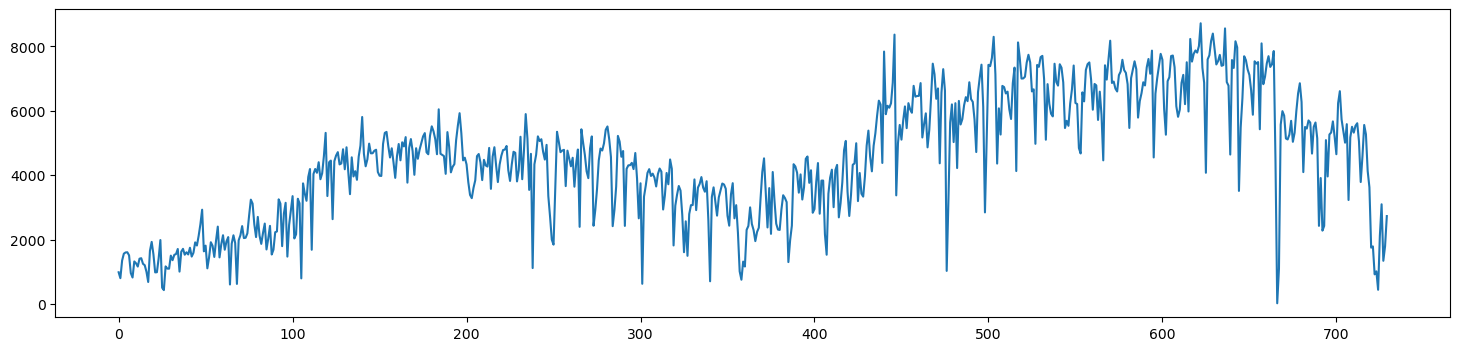

In [10]:
plt.figure(figsize=(18,4))
plt.plot(data.cnt)
plt.show()

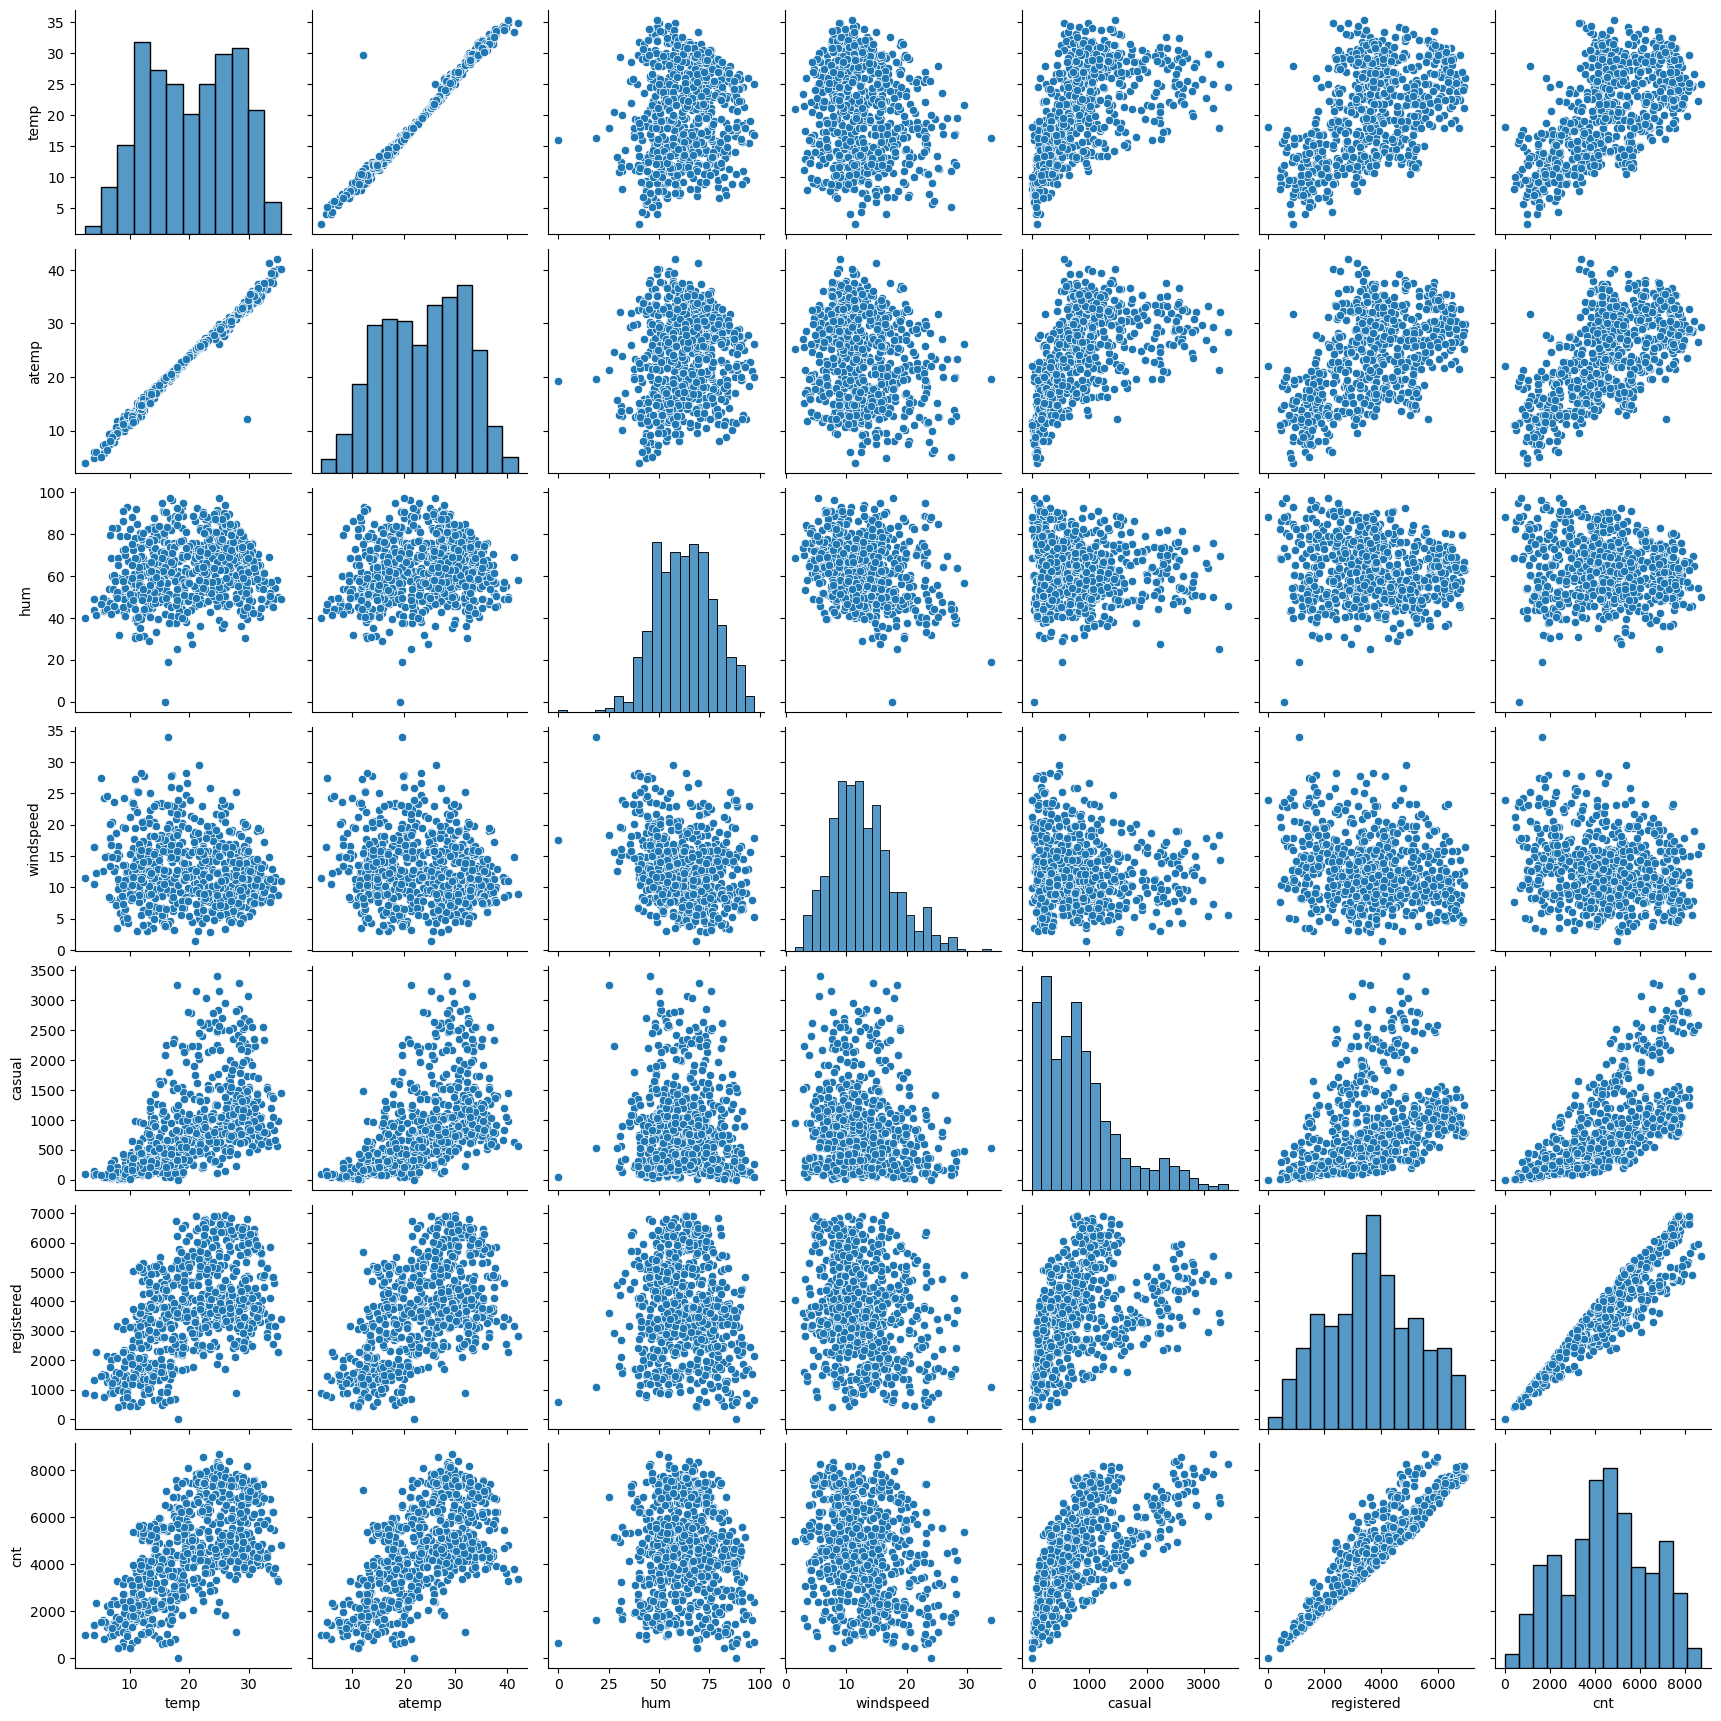

In [11]:
sns.pairplot(data, vars = numerical_features)
plt.show()

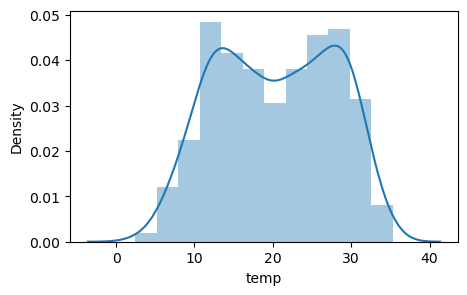

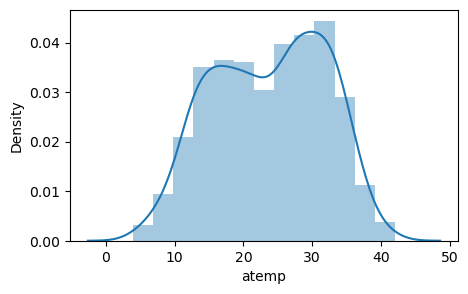

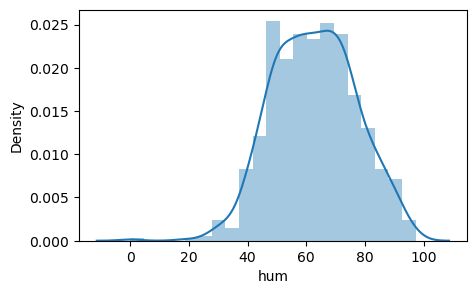

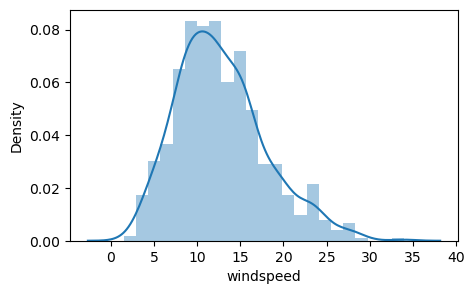

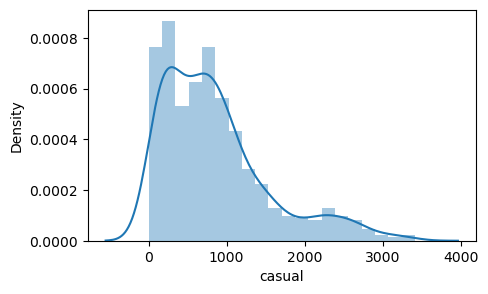

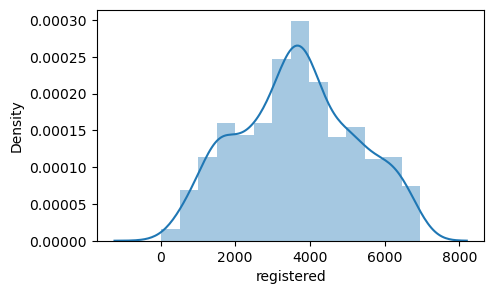

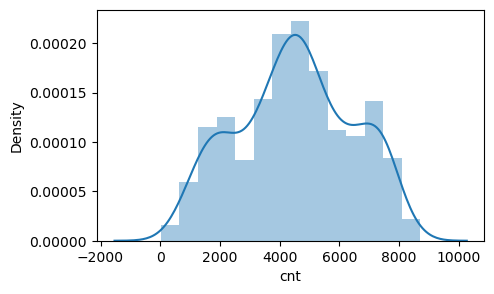

In [12]:
for i in numerical_features:
    plt.figure(figsize = (5,3))
    sns.distplot(data[i])
    plt.show()

In [13]:
sns.reset_orig()
''' method to visualize the relationship between numerical variable and the target variable
    rows : number of rows in the figure
    columns : number of columns in the figure
    ind_features : list of numerical variables for which relationship is to be visualized
    dep_variable : target variables
    data : dataframe
'''
def plotnumericals(rows, columns, ind_features, dep_variable, data=data):
    plt.figure(figsize=(8,5))
    for i in range(0, len(ind_features)) :
        plt.subplot(rows, columns, i+1)
        sns.regplot(data=data, x=ind_features[i],y=dep_variable, scatter_kws={'s':1})
    plt.show()

In [14]:
''' method to visualize the relationship between categorical variable and the target variable
    rows : number of rows in the figure
    columns : number of columns in the figure
    ind_features : list of categorical variables for which relationship is to be visualized
    dep_variable : target variables
    data : dataframe
'''
def addboxplots(rows, columns, ind_features, dep_variable, data=data):
    plt.figure(figsize=(15,15))
    for i in range(0, len(ind_features)) :
        plt.subplot(rows, columns, i+1)
        sns.boxplot(data=data, x=ind_features[i],y=dep_variable)
        plt.xticks(rotation=90)
    plt.show()

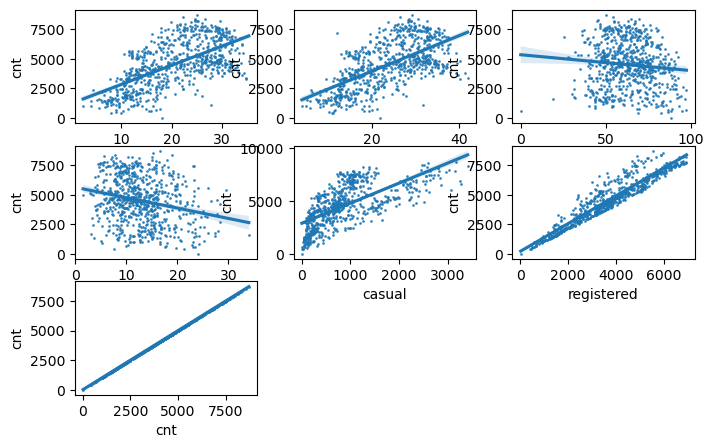

In [15]:
plotnumericals(3,3, numerical_features, 'cnt')

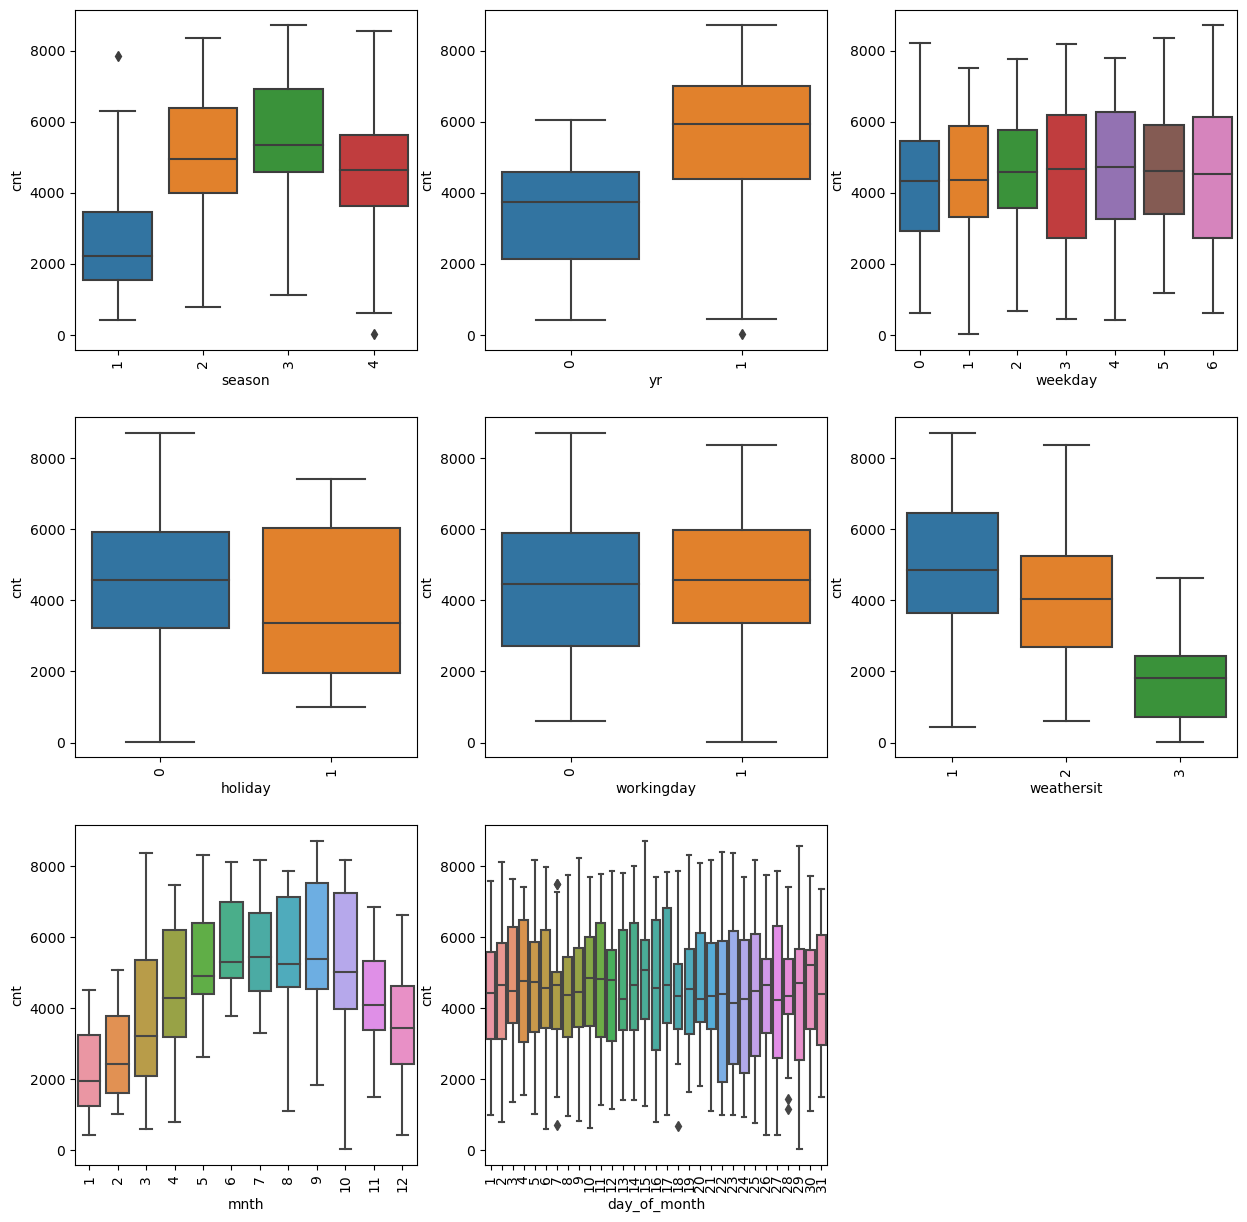

In [16]:
sns.reset_orig()

addboxplots(3,3,categorical_features, 'cnt')

In [17]:
#data['registered_percentage'] = data['registered']*100 / data['cnt']
#sns.boxplot(data, x='season',y='cnt',hue = 'registered_percentage')

data2 = data[['casual', 'registered','season','cnt']]
data2['casual'] = data2['casual']*100 / data2['cnt']
data2['registered'] = data2['registered']*100 / data2['cnt']
data2.drop(['cnt'], axis=1, inplace=True)

data3 = data2.groupby(by='season').mean()
plt.figure(figsize=(0.5,0.5))
#data3.set_index('season', inplace=True)
data3.plot(kind='bar', stacked=True, color=['red', 'pink'])

# Add Title and Labels
plt.title('season to user type%')
plt.xlabel('season')
plt.ylabel('use type % Ranges')

Text(0, 0.5, 'use type % Ranges')

In [18]:
#data['registered_percentage'] = data['registered']*100 / data['cnt']
#sns.boxplot(data, x='season',y='cnt',hue = 'registered_percentage')

data2 = data[['casual', 'registered','season','cnt']]
#data2['casual'] = data2['casual']*100 / data2['cnt']
#data2['registered'] = data2['registered']*100 / data2['cnt']
data2.drop(['cnt'], axis=1, inplace=True)

data3 = data2.groupby(by='season').sum()
plt.figure(figsize=(0.2,0.2))
#data3.set_index('season', inplace=True)
data3.plot(kind='bar', stacked=True, color=['red', 'pink'])

# Add Title and Labels
plt.title('season to user type%')
plt.xlabel('season')
plt.ylabel('use type % Ranges')

Text(0, 0.5, 'use type % Ranges')

In [19]:
''' method to visualize the relationship between categorical variable and the target variable
    rows : number of rows in the figure
    columns : number of columns in the figure
    ind_features : list of categorical variables for which relationship is to be visualized
    dep_variable : target variables
    data : dataframe
'''
def addStackedplot(rows, columns, ind_features, dep_variable, data=data):
    plt.figure(figsize=(20,11))
    for i in range(0, len(ind_features)) :
        plt.subplot(rows, columns, i+1)
        sns.boxplot(data=data, x=ind_features[i],y=dep_variable)
def stackplot(ind_feature, data=data):
    #data2 = data[['casual', 'registered','cnt',ind_feature]]
    #data3 = data2.groupby(by=ind_feature).sum()
    #data3.set_index('season', inplace=True)
    data.plot(kind='bar', stacked=True, color=['red', 'pink'])

    # Add Title and Labels
    plt.title(f"${ind_feature} to user type%")
    plt.xlabel(ind_feature)
    plt.ylabel('use type % Ranges')

## Step 2: Data preparation for modelling

In [20]:
categorical_features

['season',
 'yr',
 'weekday',
 'holiday',
 'workingday',
 'weathersit',
 'mnth',
 'day_of_month']

### 2.1 handle categorical variables

In [21]:
#season (1:spring, 2:summer, 3:fall, 4:winter)
data['season'] = data.season.apply(lambda x: 'spring' if x == 1  else ('summer' if x == 2 else ('fall' if x == 3 else ('winter' if x== 4 else 'unknown'))) )
season = pd.get_dummies(data['season'])
season.value_counts()

fall  spring  summer  winter
1     0       0       0         188
0     0       1       0         184
      1       0       0         180
      0       0       1         178
dtype: int64

In [22]:
data['weathersit'] = data.weathersit.apply(lambda x: "weathersit_"+str(x))
weathersit = pd.get_dummies(data['weathersit'])
weathersit.value_counts()

weathersit_1  weathersit_2  weathersit_3
1             0             0               463
0             1             0               246
              0             1                21
dtype: int64

In [23]:
import calendar
data['mnth'] = data['mnth'].apply(lambda x: calendar.month_abbr[x])
mnth = pd.get_dummies(data['mnth'])

In [24]:
data = pd.concat([data, season, weathersit, mnth], axis =1)
data.drop(['season','weathersit','mnth'], axis=1, inplace=True)
data.head()

yr  holiday  weekday  workingday       temp     atemp      hum  windspeed  \
0   0        0        6           0  14.110847  18.18125  80.5833  10.749882   
1   0        0        0           0  14.902598  17.68695  69.6087  16.652113   
2   0        0        1           1   8.050924   9.47025  43.7273  16.636703   
3   0        0        2           1   8.200000  10.60610  59.0435  10.739832   
4   0        0        3           1   9.305237  11.46350  43.6957  12.522300   

   casual  registered  ...  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep  
0     331         654  ...    0    0    1    0    0    0    0    0    0    0  
1     131         670  ...    0    0    1    0    0    0    0    0    0    0  
2     120        1229  ...    0    0    1    0    0    0    0    0    0    0  
3     108        1454  ...    0    0    1    0    0    0    0    0    0    0  
4      82        1518  ...    0    0    1    0    0    0    0    0    0    0  

[5 rows x 31 columns]

### 2.2 : Split the dataset into train and test

In [25]:
numerical_features

['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [26]:
numerical_features.remove('registered')
numerical_features.remove('casual')
numerical_features.remove('atemp')

data.drop(['casual','registered','atemp'], axis=1, inplace=True)
#df_train, df_test = train_test_split(data, train_size = 0.7, random_state=100)
df_train, df_test = train_test_split(data, train_size = 0.7, random_state=37)
(df_train.shape, df_test.shape)

((510, 28), (220, 28))

### 2.3 : Rescaling the features
1. min-Max Scaling/Normalization : Between 0 and 1 [using here] : (x-xmin) / (xmax-xmin)
2. Standardization (mean =0, sigma =1) : (x - mu ) / sigma

In [27]:
# 1. instantiate an object of MinMax
scaler = MinMaxScaler()

#2. Fit MinMaxScaler on training dataset
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_train.head()

yr  holiday  weekday  workingday      temp       hum  windspeed  \
720   1        0        6           0  0.225205  0.453728   0.962667   
395   1        0        2           1  0.390362  0.428449   0.598738   
553   1        0        0           0  0.965639  0.589974   0.258169   
112   0        0        6           0  0.483470  0.913025   0.520985   
417   1        0        3           1  0.398120  0.583976   0.530353   

          cnt  day_of_month  fall  ...  Dec  Feb  Jan  Jul  Jun  Mar  May  \
720  0.159121            22     0  ...    1    0    0    0    0    0    0   
395  0.492334            31     0  ...    0    0    1    0    0    0    0   
553  0.512013             8     1  ...    0    0    0    1    0    0    0   
112  0.435229            23     0  ...    0    0    0    0    0    0    0   
417  0.524206            22     0  ...    0    1    0    0    0    0    0   

     Nov  Oct  Sep  
720    0    0    0  
395    0    0    0  
553    0    0    0  
112    0    0    0  
417    0    0    0  

[5 rows x 28 columns]

In [28]:
df_train[numerical_features].describe()

temp         hum   windspeed         cnt
count  510.000000  510.000000  510.000000  510.000000
mean     0.521712    0.641881    0.424117    0.490588
std      0.240204    0.146369    0.188015    0.226461
min      0.000000    0.000000    0.000000    0.000000
25%      0.312217    0.533042    0.286237    0.339672
50%      0.500097    0.640317    0.400445    0.489436
75%      0.735085    0.743359    0.530222    0.659574
max      1.000000    1.000000    1.000000    1.000000

In [29]:
# apply same set of transformations on test dataset
df_test[numerical_features] = scaler.transform(df_test[numerical_features])
df_test.describe()

yr     holiday     weekday  workingday        temp         hum  \
count  220.000000  220.000000  220.000000  220.000000  220.000000  220.000000   
mean     0.477273    0.009091    3.318182    0.695455    0.551906    0.653558   
std      0.500622    0.095128    1.948805    0.461264    0.250363    0.146486   
min      0.000000    0.000000    0.000000    0.000000   -0.049735    0.193231   
25%      0.000000    0.000000    2.000000    0.000000    0.328012    0.538239   
50%      0.000000    0.000000    3.000000    1.000000    0.592699    0.658312   
75%      1.000000    0.000000    5.000000    1.000000    0.781639    0.759640   
max      1.000000    1.000000    6.000000    1.000000    1.017736    0.976435   

        windspeed         cnt  day_of_month        fall  ...         Dec  \
count  220.000000  220.000000    220.000000  220.000000  ...  220.000000   
mean     0.411776    0.495982     15.827273    0.300000  ...    0.077273   
std      0.207186    0.250277      8.989958    0.459303  ...    0.267633   
min      0.057548   -0.049378      1.000000    0.000000  ...    0.000000   
25%      0.262707    0.300918      8.000000    0.000000  ...    0.000000   
50%      0.384899    0.507183     15.500000    0.000000  ...    0.000000   
75%      0.518245    0.704998     24.000000    1.000000  ...    0.000000   
max      1.213032    0.980804     31.000000    1.000000  ...    1.000000   

              Feb         Jan         Jul         Jun         Mar         May  \
count  220.000000  220.000000  220.000000  220.000000  220.000000  220.000000   
mean     0.077273    0.077273    0.090909    0.095455    0.095455    0.100000   
std      0.267633    0.267633    0.288135    0.294512    0.294512    0.300684   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              Nov         Oct         Sep  
count  220.000000  220.000000  220.000000  
mean     0.050000    0.077273    0.104545  
std      0.218442    0.267633    0.306665  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000  

[8 rows x 28 columns]

## Step 3. Training the Linear regression model

In [30]:
#plt.figure(figsize = (16,10))
#sns.heatmap(df_train.corr(), annot=True, cmap = 'YlGnBu')
#plt.show()
        

In [31]:
def plot_cluster(columns, df = data, font_size=2):
    """
        Parameters:
            columns: columns to be considered for crrelation
            df: dataframe, defaulted to loan
            font_size : size defaulted to 2
        Returns:
            None, does a clustermap plot
    """
    dfToCorr = df[columns]
    df_corr = dfToCorr.corr()
    
    sns.set(font_scale=font_size)
    cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
    sns.clustermap(df_corr, annot=True, figsize=(30, 20),cmap="BrBG")

In [32]:
columnsToCorr1 = df_train.columns.difference({'day_of_month','registered','casual', 'atemp'}).to_list()
plot_cluster(columnsToCorr1, df_train.corr(), 1.7)

In [33]:
# x_train, y_train
y_train, X_train = df_train.pop('cnt'), df_train
# train test for model 1
y_train1, X_train1 = y_train, X_train
# train test for model 2
y_train2, X_train2 = y_train, X_train

- statistical significance of the variable
- VIF comparison

In [34]:
def buildAndTrainModel(ind_vars, data = X_train, target = y_train):
    # filter the subset of columns from original df_train set
    data_sm = data[ind_vars]
    # add constant
    data_sm = sm.add_constant(data_sm)
    # create the model
    lr = sm.OLS(target, data_sm)
    # fit the model
    lr_model = lr.fit()
    # print params
    print((lr_model.params, lr_model.summary()))
    return lr_model

In [35]:
def calculateVIF(data):
    vif = pd.DataFrame()
    vif['Features'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = 'VIF', ascending= False)
    print(vif)

### Step 3.1 : Approach 1 : manual feature reduction
manually reducing the feature set based on pvalues and VIF scores

In [36]:
buildAndTrainModel(list(X_train.columns), X_train, y_train)

(const           0.133830
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
fall            0.019641
spring         -0.061627
summer          0.068949
winter          0.106866
weathersit_1    0.139346
weathersit_2    0.085616
weathersit_3   -0.091132
Apr             0.000825
Aug             0.027930
Dec            -0.031396
Feb            -0.012932
Jan            -0.035582
Jul             0.006352
Jun             0.015357
Mar             0.001779
May             0.019865
Nov            -0.017383
Oct             0.059491
Sep             0.099524
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.84

1. atemp, mnth, day_of_month are having high p values and can be considered for removal
before that lets look at VIF
2. 
A> All high : 
1. High p value, High VIF  : remove the feature
B> High -Lows : 
2. High p value, Low VIF   : remove these first : and then 3
3. Low p value , High VIF  : 
C> All lows : 
4. Low p value, Low VIF    :  keep

atemp has highest p value from the model summary output
as well as higher VIF value too,
So lets remove the atemp variable and verify the VIF values for remaining vars

In [37]:
# cat 1 : all Highs
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.133830
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
fall            0.019641
spring         -0.061627
summer          0.068949
winter          0.106866
weathersit_1    0.139346
weathersit_2    0.085616
weathersit_3   -0.091132
Apr             0.000825
Aug             0.027930
Dec            -0.031396
Feb            -0.012932
Jan            -0.035582
Jul             0.006352
Jun             0.015357
Mar             0.001779
May             0.019865
Nov            -0.017383
Oct             0.059491
Sep             0.099524
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.84

In [38]:
## observations : removing atemp has not impacted the r squared value at all 

In [39]:
# fall :  cat 1 : all Highs
X_train1 = X_train1.drop(['fall'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.147694
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
spring         -0.081268
summer          0.049308
winter          0.087225
weathersit_1    0.143967
weathersit_2    0.090238
weathersit_3   -0.086511
Apr             0.001980
Aug             0.029086
Dec            -0.030241
Feb            -0.011776
Jan            -0.034427
Jul             0.007507
Jun             0.016513
Mar             0.002935
May             0.021020
Nov            -0.016228
Oct             0.060646
Sep             0.100680
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                

In [40]:
## observations : removing fall has not impacted the r squared value at all 

In [41]:
# day_of_month :  cat 1 : all Highs
X_train1 = X_train1.drop(['day_of_month'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.144444
yr              0.241518
holiday        -0.046425
weekday         0.008101
workingday      0.018785
temp            0.399216
hum            -0.164469
windspeed      -0.138426
spring         -0.080662
summer          0.047697
winter          0.089653
weathersit_1    0.142081
weathersit_2    0.089257
weathersit_3   -0.086894
Apr             0.002898
Aug             0.029496
Dec            -0.032898
Feb            -0.012388
Jan            -0.036317
Jul             0.007555
Jun             0.018988
Mar             0.002336
May             0.023313
Nov            -0.018387
Oct             0.058209
Sep             0.101638
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statis

In [42]:
## observations : removing day_of_month has not impacted the r squared value at all 

In [43]:
# Jul :  cat 1 : all Highs
X_train1 = X_train1.drop(['Jul'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.150110
yr              0.241518
holiday        -0.046425
weekday         0.008101
workingday      0.018785
temp            0.399216
hum            -0.164469
windspeed      -0.138426
spring         -0.080662
summer          0.047697
winter          0.089653
weathersit_1    0.143970
weathersit_2    0.091146
weathersit_3   -0.085005
Apr            -0.004657
Aug             0.021941
Dec            -0.040453
Feb            -0.019943
Jan            -0.043872
Jun             0.011433
Mar            -0.005219
May             0.015758
Nov            -0.025942
Oct             0.050654
Sep             0.094083
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     

In [44]:
# remove Feb : 
X_train1 = X_train1.drop(['Feb'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.144177
yr              0.241174
holiday        -0.047105
weekday         0.008080
workingday      0.018338
temp            0.409021
hum            -0.167001
windspeed      -0.139000
spring         -0.090538
summer          0.042235
winter          0.083343
weathersit_1    0.141631
weathersit_2    0.089127
weathersit_3   -0.086581
Apr             0.006358
Aug             0.024567
Dec            -0.025272
Jan            -0.025407
Jun             0.018524
Mar             0.009701
May             0.025514
Nov            -0.012660
Oct             0.062483
Sep             0.099408
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     127.2
Date:              

In [45]:
# Jul :  
X_train1 = X_train1.drop(['Nov'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.142289
yr              0.241170
holiday        -0.048193
weekday         0.008033
workingday      0.018291
temp            0.412624
hum            -0.168620
windspeed      -0.140003
spring         -0.089493
summer          0.042948
winter          0.076162
weathersit_1    0.140909
weathersit_2    0.088727
weathersit_3   -0.087347
Apr             0.008015
Aug             0.025783
Dec            -0.017957
Jan            -0.022986
Jun             0.019244
Mar             0.011518
May             0.026663
Oct             0.072008
Sep             0.102766
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     133.4
Date:                Wed, 08 Feb 2023   Prob

In [46]:
# Dec :  
X_train1 = X_train1.drop(['Dec'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.139182
yr              0.240964
holiday        -0.048085
weekday         0.008098
workingday      0.018483
temp            0.419199
hum            -0.172632
windspeed      -0.138545
spring         -0.090327
summer          0.042831
winter          0.073797
weathersit_1    0.139477
weathersit_2    0.087187
weathersit_3   -0.087481
Apr             0.010791
Aug             0.026879
Jan            -0.017386
Jun             0.020414
Mar             0.015531
May             0.029107
Oct             0.077505
Sep             0.105379
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     140.0
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          

In [47]:
# Apr :  
X_train1 = X_train1.drop(['Apr'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.139927
yr              0.241003
holiday        -0.048217
weekday         0.008120
workingday      0.018400
temp            0.420109
hum            -0.173638
windspeed      -0.138211
spring         -0.089756
summer          0.050214
winter          0.073214
weathersit_1    0.139487
weathersit_2    0.087354
weathersit_3   -0.086913
Aug             0.025840
Jan            -0.018530
Jun             0.013672
Mar             0.011514
May             0.020884
Oct             0.077327
Sep             0.104614
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.6
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          9.12e-189
Time:          

In [48]:
# Jun :  
X_train1 = X_train1.drop(['Jun'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.136952
yr              0.240808
holiday        -0.049299
weekday         0.008169
workingday      0.018123
temp            0.430712
hum            -0.176231
windspeed      -0.139491
spring         -0.085840
summer          0.055505
winter          0.075837
weathersit_1    0.138152
weathersit_2    0.086495
weathersit_3   -0.087695
Aug             0.023723
Jan            -0.018045
Mar             0.009493
May             0.015304
Oct             0.075748
Sep             0.103378
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     155.9
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          9.34e-190
Time:                        15:37:35   

In [49]:
# Mar :  
X_train1 = X_train1.drop(['Mar'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.139113
yr              0.240724
holiday        -0.050122
weekday         0.008157
workingday      0.018096
temp            0.429487
hum            -0.178347
windspeed      -0.139668
spring         -0.083634
summer          0.056721
winter          0.075291
weathersit_1    0.138384
weathersit_2    0.087250
weathersit_3   -0.086521
Aug             0.023731
Jan            -0.021095
May             0.013989
Oct             0.075991
Sep             0.103453
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          8.46e-191
Time:                        15:37:35   Log-Likelihood:          

In [50]:
# May :  
X_train1 = X_train1.drop(['May'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.134569
yr              0.240589
holiday        -0.049490
weekday         0.008167
workingday      0.018244
temp            0.432725
hum            -0.173295
windspeed      -0.140496
spring         -0.081623
summer          0.061779
winter          0.076611
weathersit_1    0.137541
weathersit_2    0.085758
weathersit_3   -0.088730
Aug             0.023585
Jan            -0.020858
Oct             0.075358
Sep             0.103141
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     175.7
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          8.64e-192
Time:                        15:37:35   Log-Likelihood:                 519.41
No. Observa

In [51]:
# spring :  
X_train1 = X_train1.drop(['spring'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.077478
yr              0.237978
holiday        -0.053967
weekday         0.008400
workingday      0.015203
temp            0.516979
hum            -0.185702
windspeed      -0.144945
summer          0.103342
winter          0.133929
weathersit_1    0.115464
weathersit_2    0.064723
weathersit_3   -0.102709
Aug             0.046444
Jan            -0.027913
Oct             0.065471
Sep             0.124360
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     182.1
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.88e-190
Time:                        15:37:35   Log-Likelihood:                 512.73
No. Observations:                 51

In [52]:
# weathersit_1 :  
X_train1 = X_train1.drop(['weathersit_1'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.192942
yr              0.237978
holiday        -0.053967
weekday         0.008400
workingday      0.015203
temp            0.516979
hum            -0.185702
windspeed      -0.144945
summer          0.103342
winter          0.133929
weathersit_2   -0.050742
weathersit_3   -0.218173
Aug             0.046444
Jan            -0.027913
Oct             0.065471
Sep             0.124360
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     182.1
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.88e-190
Time:                        15:37:35   Log-Likelihood:                 512.73
No. Observations:                 510   AIC:                 

In [53]:
# hum :  
X_train1 = X_train1.drop(['hum'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.084658
yr              0.242793
holiday        -0.053328
weekday         0.009233
workingday      0.018168
temp            0.490932
windspeed      -0.115744
summer          0.101874
winter          0.123568
weathersit_2   -0.081815
weathersit_3   -0.268647
Aug             0.043828
Jan            -0.034830
Oct             0.063460
Sep             0.113218
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.7
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.60e-186
Time:                        15:37:35   Log-Likelihood:                 500.53
No. Observations:                 510   AIC:                            -971.1
Df Resi

In [54]:
# workingday :  
X_train1 = X_train1.drop(['workingday'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.096212
yr              0.242449
holiday        -0.065530
weekday         0.009635
temp            0.493503
windspeed      -0.118523
summer          0.101864
winter          0.123303
weathersit_2   -0.081019
weathersit_3   -0.267125
Aug             0.042547
Jan            -0.033594
Oct             0.061982
Sep             0.112964
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.5
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          1.72e-186
Time:                        15:37:35   Log-Likelihood:                 498.53
No. Observations:                 510   AIC:                            -969.1
Df Residuals:                   

In [55]:
# Oct : 
X_train1 = X_train1.drop(['Oct'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.086697
yr              0.241671
holiday        -0.064284
weekday         0.009778
temp            0.511121
windspeed      -0.116342
summer          0.099429
winter          0.145728
weathersit_2   -0.079678
weathersit_3   -0.266685
Aug             0.036294
Jan            -0.029148
Sep             0.103789
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     208.0
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          5.69e-185
Time:                        15:37:35   Log-Likelihood:                 492.14
No. Observations:                 510   AIC:                            -958.3
Df Residuals:                     497   BIC:             

In [56]:
# Aug :  
X_train1 = X_train1.drop(['Aug'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.084472
yr              0.240677
holiday        -0.066595
weekday         0.009783
temp            0.528689
windspeed      -0.114963
summer          0.090645
winter          0.140586
weathersit_2   -0.078189
weathersit_3   -0.268089
Jan            -0.030854
Sep             0.094389
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     225.1
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          2.86e-185
Time:                        15:37:35   Log-Likelihood:                 490.04
No. Observations:                 510   AIC:                            -956.1
Df Residuals:                     498   BIC:                            -905.3
Df 

In [57]:
# Jan :  
X_train1 = X_train1.drop(['Jan'], axis=1)
buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.069224
yr              0.239796
holiday        -0.067943
weekday         0.009817
temp            0.545597
windspeed      -0.113099
summer          0.095372
winter          0.148131
weathersit_2   -0.078026
weathersit_3   -0.268533
Sep             0.095859
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     246.3
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          8.15e-186
Time:                        15:37:35   Log-Likelihood:                 488.47
No. Observations:                 510   AIC:                            -954.9
Df Residuals:                     499   BIC:                            -908.4
Df Model:                   

In [58]:
# holiday : 
X_train1 = X_train1.drop(['holiday'], axis=1)
lr_model1 = buildAndTrainModel(list(X_train1.columns), X_train1, y_train)
calculateVIF(X_train1)

(const           0.063788
yr              0.240153
weekday         0.010609
temp            0.547882
windspeed      -0.115506
summer          0.096002
winter          0.148330
weathersit_2   -0.077637
weathersit_3   -0.265212
Sep             0.094016
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     268.2
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          4.98e-185
Time:                        15:37:35   Log-Likelihood:                 483.72
No. Observations:                 510   AIC:                            -947.4
Df Residuals:                     500   BIC:                            -905.1
Df Model:                           9                

In [59]:
# weekday :  
X_train1 = X_train1.drop(['weekday'], axis=1)
lr_model1 = buildAndTrainModel(list(X_train1.columns), X_train1, y_train1)
calculateVIF(X_train1)

(const           0.093700
yr              0.240337
temp            0.545839
windspeed      -0.111067
summer          0.093180
winter          0.146942
weathersit_2   -0.076342
weathersit_3   -0.264067
Sep             0.095763
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     284.4
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          8.06e-181
Time:                        15:37:35   Log-Likelihood:                 470.88
No. Observations:                 510   AIC:                            -923.8
Df Residuals:                     501   BIC:                            -885.6
Df Model:                           8                                         

In [60]:
# windspeed :  cat 1 : all Highs
#X_train1 = X_train1.drop(['windspeed'], axis=1)
#lr_model =  buildAndTrainModel(list(X_train1.columns), X_train1, y_train)
##calculateVIF(X_train1)

In [61]:
# Model 1 : Manually processed regression model :
X_train1 # dataset with reduced columns
lr_model1.summary() # model 1
calculateVIF(X_train1)

       Features   VIF
1          temp  3.74
2     windspeed  3.48
0            yr  1.99
3        summer  1.63
5  weathersit_2  1.48
4        winter  1.37
7           Sep  1.19
6  weathersit_3  1.07


# Step  3.2 : Approach 2 : Using RFE 
Reduce the feature set using an RFE and then manually reduce it further

In [62]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor

In [63]:
# Exploring RFECV, however RFE will be used 
rfecv = RFECV(estimator=DecisionTreeRegressor())
# fit RFE
rfecv.fit(X_train2, y_train2)
cols = X_train2.columns
# summarize all features
for i in range(X_train2.shape[1]):
 print('Column: %s, Selected %s, Rank: %.3f' % (cols[i], rfecv.support_[i], rfecv.ranking_[i]))

Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: weekday, Selected True, Rank: 1.000
Column: workingday, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: day_of_month, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected False, Rank: 2.000
Column: Apr, Selected True, Rank: 1.000
Column: Aug, Selected False, Rank: 3.000
Column: Dec, Selected True, Rank: 1.000
Column: Feb, Selected True, Rank: 1.000
Column: Jan, Selected True, Rank: 1.000
Column: Jul, Selected True, Rank: 1.000
Column: Jun, Selected True, Rank: 1.000
Column: Mar, Selected True, Rank: 1.000
Column: May

In [64]:
# iteratively removing features using RFE

In [65]:
from sklearn.linear_model import LinearRegression
def runRFE(n_features_to_select, data = X_train2, target = y_train2):
    # Construct our Linear Regression model
    lr = LinearRegression()
    lr.fit(data, target)
#    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_features_to_select,step=10)
    rfe = RFE(lr, n_features_to_select=n_features_to_select,step=10, verbose =3)
    # fit RFE
    rfe.fit(data, target)
    # summarize all features
    cols = data.columns
    for i in range(data.shape[1]):
        print('Column: %s, Selected %s, Rank: %.3f' % (cols[i], rfe.support_[i], rfe.ranking_[i]))
    return rfe

In [66]:
def removeUnsupportedColumns(rfe, data):
    keep_list = rfe.support_
    columnsToRemove = data.columns.values[np.logical_not(keep_list)]
    d = data.drop(columns=columnsToRemove)
    return d

In [67]:
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.133830
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
fall            0.019641
spring         -0.061627
summer          0.068949
winter          0.106866
weathersit_1    0.139346
weathersit_2    0.085616
weathersit_3   -0.091132
Apr             0.000825
Aug             0.027930
Dec            -0.031396
Feb            -0.012932
Jan            -0.035582
Jul             0.006352
Jun             0.015357
Mar             0.001779
May             0.019865
Nov            -0.017383
Oct             0.059491
Sep             0.099524
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.84

In [68]:
X_train2 = X_train
#Based on manual analysis done eariler, removing some 'hum'
X_train2= X_train2.drop(['hum'], axis=1)
rfe = runRFE(7, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

lr_model2 = buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

Fitting estimator with 26 features.
Fitting estimator with 16 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected False, Rank: 2.000
Column: weekday, Selected False, Rank: 3.000
Column: workingday, Selected False, Rank: 3.000
Column: temp, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: day_of_month, Selected False, Rank: 3.000
Column: fall, Selected False, Rank: 3.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected False, Rank: 2.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected False, Rank: 2.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Apr, Selected False, Rank: 3.000
Column: Aug, Selected False, Rank: 3.000
Column: Dec, Selected False, Rank: 2.000
Column: Feb, Selected False, Rank: 2.000
Column: Jan, Selected False, Rank: 2.000
Column: Jul, Selected False, Rank: 3.000
Column: Jun, Selected False, Rank: 3.000
Column:

### Step  3.3 : Approach 3 : Model by removing highly correlated features 

In [69]:
X_train3, y_train3  = X_train, y_train

#X_train3= X_train3.drop(['weathersit_3','Sep','windspeed','winter'], axis=1)
X_train3= X_train3.drop(['hum'], axis=1)

#identify highly correlated variables 
cor_matrix = X_train3.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.40)]
print('highly correlated variables : ',to_drop)

X_train3 = X_train3.drop(to_drop, axis=1)

highly correlated variables :  ['fall', 'spring', 'weathersit_2', 'Apr', 'Aug', 'Feb', 'Jan', 'Jul', 'May', 'Nov', 'Oct']


In [70]:
# use RFE to select 11 features
rfe = runRFE(11, X_train3, y_train3)
X_train3 = removeUnsupportedColumns(rfe, X_train3)
lr_model3 = buildAndTrainModel(list(X_train3.columns), X_train3, y_train3)
calculateVIF(X_train3)

Fitting estimator with 15 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: weekday, Selected False, Rank: 2.000
Column: workingday, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: day_of_month, Selected False, Rank: 2.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Dec, Selected True, Rank: 1.000
Column: Jun, Selected False, Rank: 2.000
Column: Mar, Selected False, Rank: 2.000
Column: Sep, Selected True, Rank: 1.000
(const           0.016201
yr              0.240267
holiday        -0.067249
workingday      0.019152
temp            0.532610
windspeed      -0.110305
summer          0.090532
winter          0.152326
weathersit_1    0.076471
weathersit_3   -0.194423
Dec            -0.037326
Sep             0.095142
dtype

In [71]:
# refine the above model considering pvalue and VIF scores
X_train3 = X_train3.drop(['Dec','workingday','holiday'], axis=1)
rfe = runRFE(11, X_train3, y_train3)
X_train3 = removeUnsupportedColumns(rfe, X_train3)
lr_model3 = buildAndTrainModel(list(X_train3.columns), X_train3, y_train3)
calculateVIF(X_train3)

Column: yr, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Sep, Selected True, Rank: 1.000
(const           0.017358
yr              0.240337
temp            0.545839
windspeed      -0.111067
summer          0.093180
winter          0.146942
weathersit_1    0.076342
weathersit_3   -0.187725
Sep             0.095763
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     284.4
Date:                Wed, 08 Feb 2023   Prob

## Step 4 : Residual Analysis & Assumptions verification

In [72]:
sns.reset_orig()
def predictUsingSM(model, data):
    # filter the subset of columns from original df_train set
    data_sm = data[data.columns]
    # add constant
    data_sm = sm.add_constant(data_sm)
    y_train1_pred = model.predict(data_sm)
    return y_train1_pred
def calculateResidue(y, y_pred):
    return y - y_pred
def plotResidual(y, y_pred, rows, columns, index):
    print("Analysis 1: Residual Plot : \n Values Should be normally distributed")
    res = calculateResidue(y, y_pred)
    plt.figure(figsize=(4,2))
    sns.displot(res)
    plt.title("1. Error Terms")
    plt.xlabel('Errors')
    plt.show()

def verifyIndependanceOfResiduals(y, y_pred):
     print("Analysis 2. Independence of residuals \n durbin_watson : ", durbin_watson(calculateResidue(y, y_pred)))
        
def verifyHomoscedasticity(data, y, y_pred, rows, columns, index):
    print("Analysis 3 : Homoscedasticity : \n Should not see any patterns in below scatterplot..")
    res =   calculateResidue(y, y_pred)
    plt.figure(figsize=(4,2))
    plt.scatter(y, res)
    plt.plot(y,(y - y), '-r')
    plt.title("2. Homoscedasticity")
    plt.xlabel('Count')
    plt.ylabel('Residual')
    plt.show()

def verifyLinearity(rows, columns, model, features):
    plt.figure(figsize=(5,5))
    fig = plt.figure(figsize=(rows,columns))
    sm.graphics.plot_ccpr_grid(model, fig=fig)
    plt.title("Analysis 4.Linearity")
    
    plt.show()

def verifyMultiColinearity(data, rows, columns, index):
    calculateVIF(data)
    plt.figure(figsize=(5,5))
    sns.heatmap(data.corr(),annot = True, cmap="RdYlGn")
    plt.title("Analysis 5. MultiColinearity")
    plt.show()

def residualAnalysis(model, data, target):
    target_pred = predictUsingSM(model, data )
    plotResidual(target, target_pred, 3,1, 1) 
    verifyIndependanceOfResiduals(target, target_pred)
    verifyHomoscedasticity(data, target, target_pred,3,1, 2)
    verifyMultiColinearity(data,3,1, 3)
    verifyLinearity(11,11, model, data.columns)
    

Analysis 1: Residual Plot : 
 Values Should be normally distributed


<Figure size 50x50 with 0 Axes>

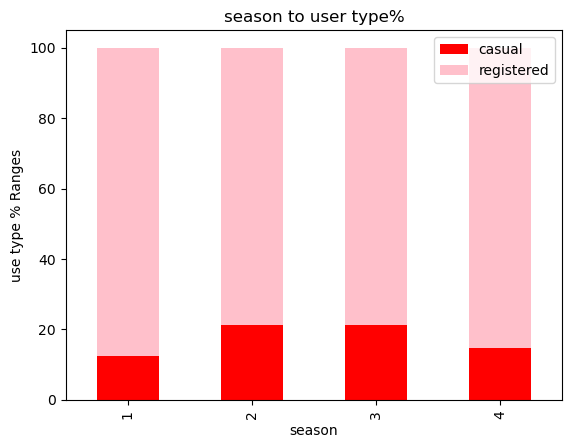

<Figure size 20x20 with 0 Axes>

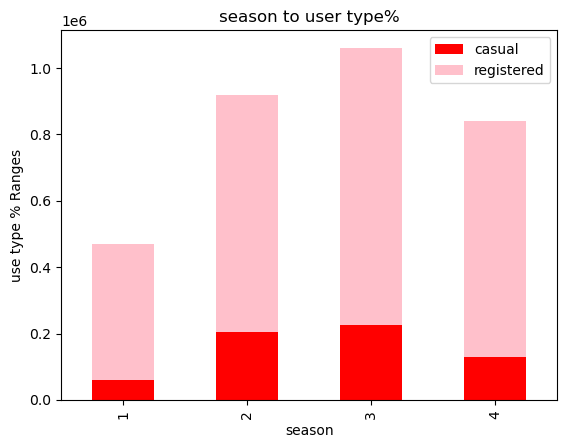

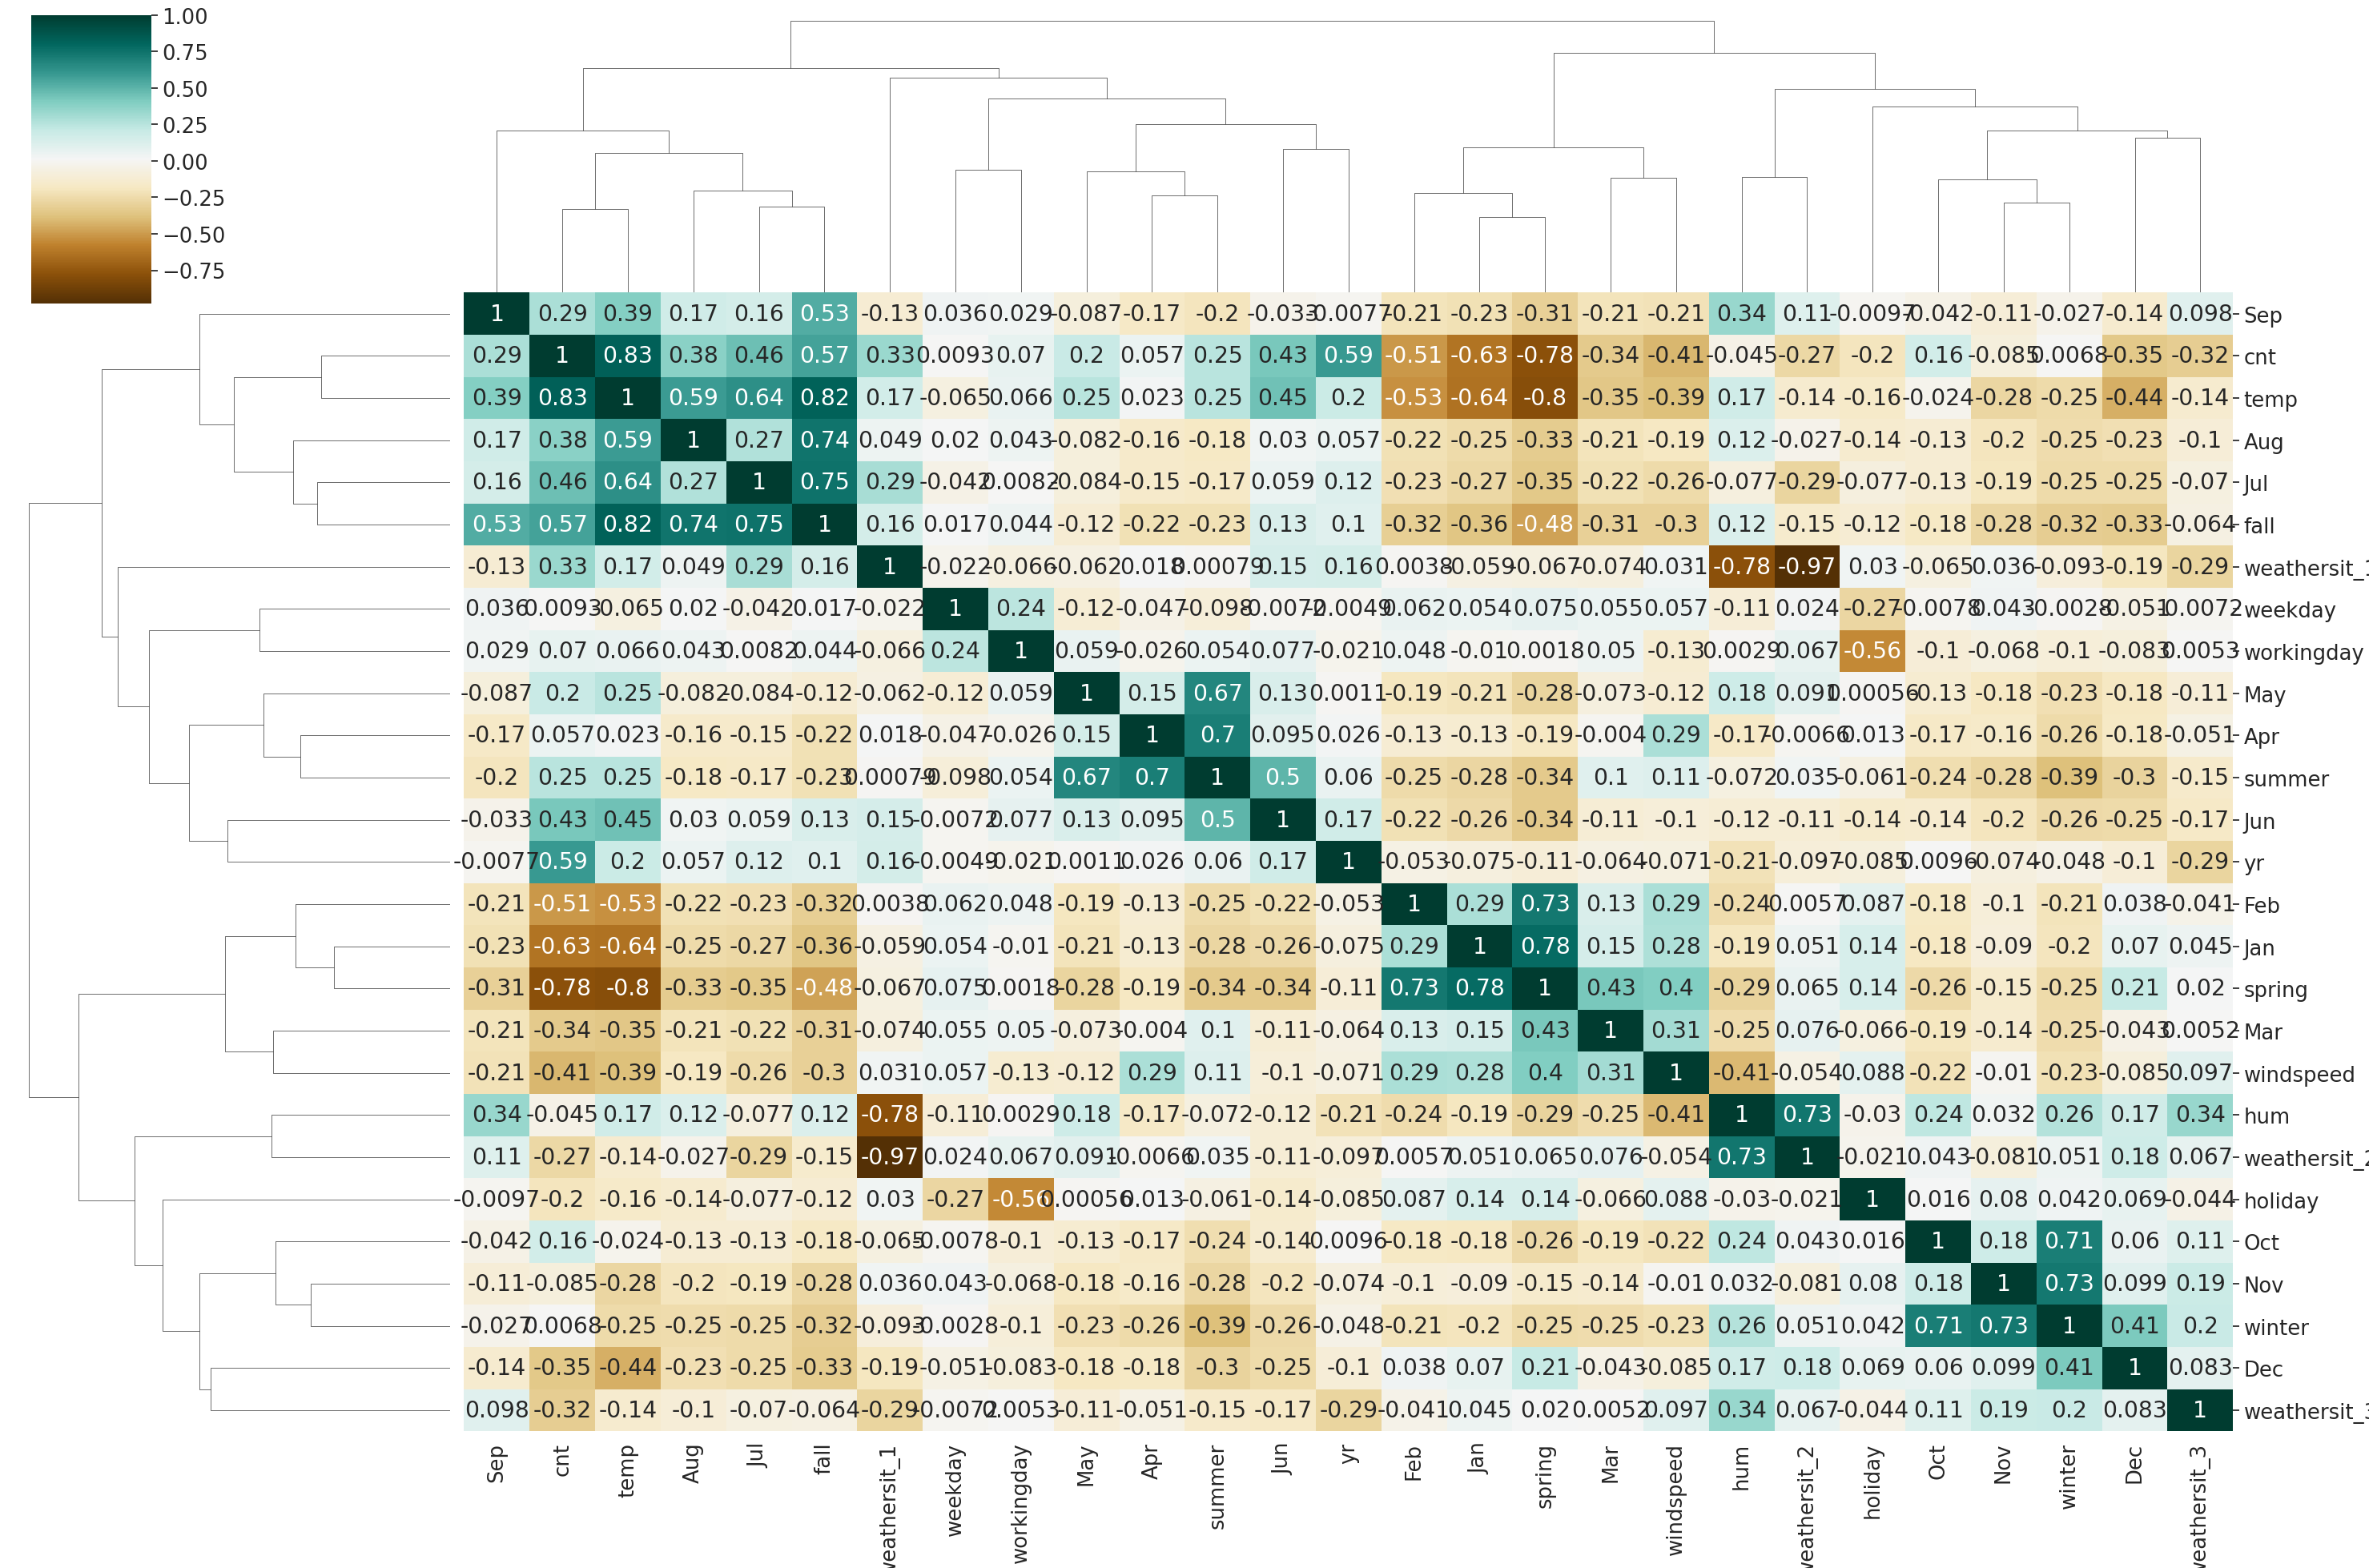

<Figure size 400x200 with 0 Axes>

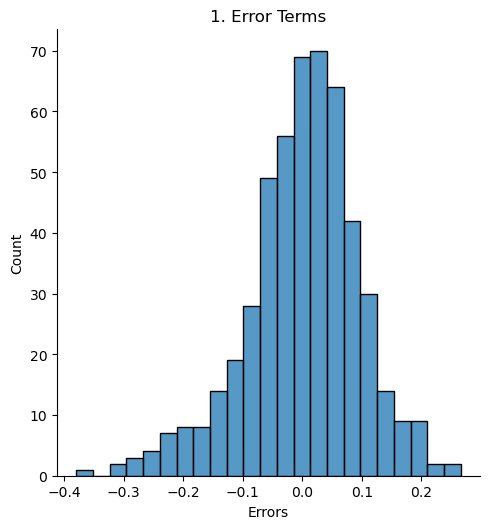

Analysis 2. Independence of residuals 
 durbin_watson :  2.1349355477087633
Analysis 3 : Homoscedasticity : 
 Should not see any patterns in below scatterplot..


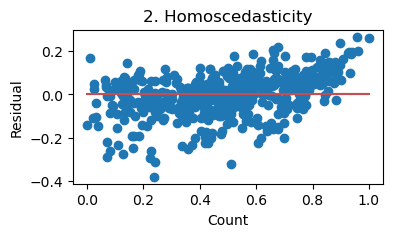

       Features   VIF
1          temp  3.74
2     windspeed  3.48
0            yr  1.99
3        summer  1.63
5  weathersit_2  1.48
4        winter  1.37
7           Sep  1.19
6  weathersit_3  1.07


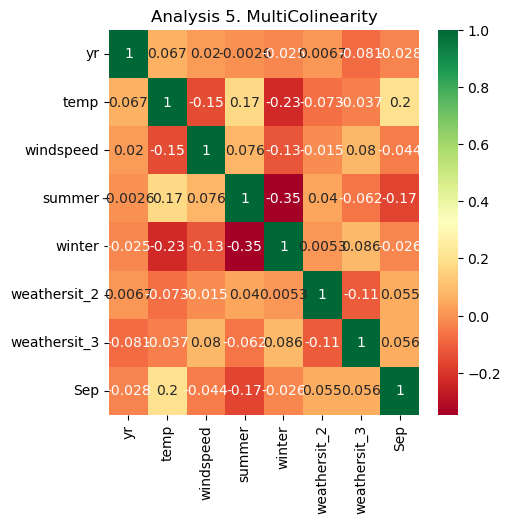

<Figure size 500x500 with 0 Axes>

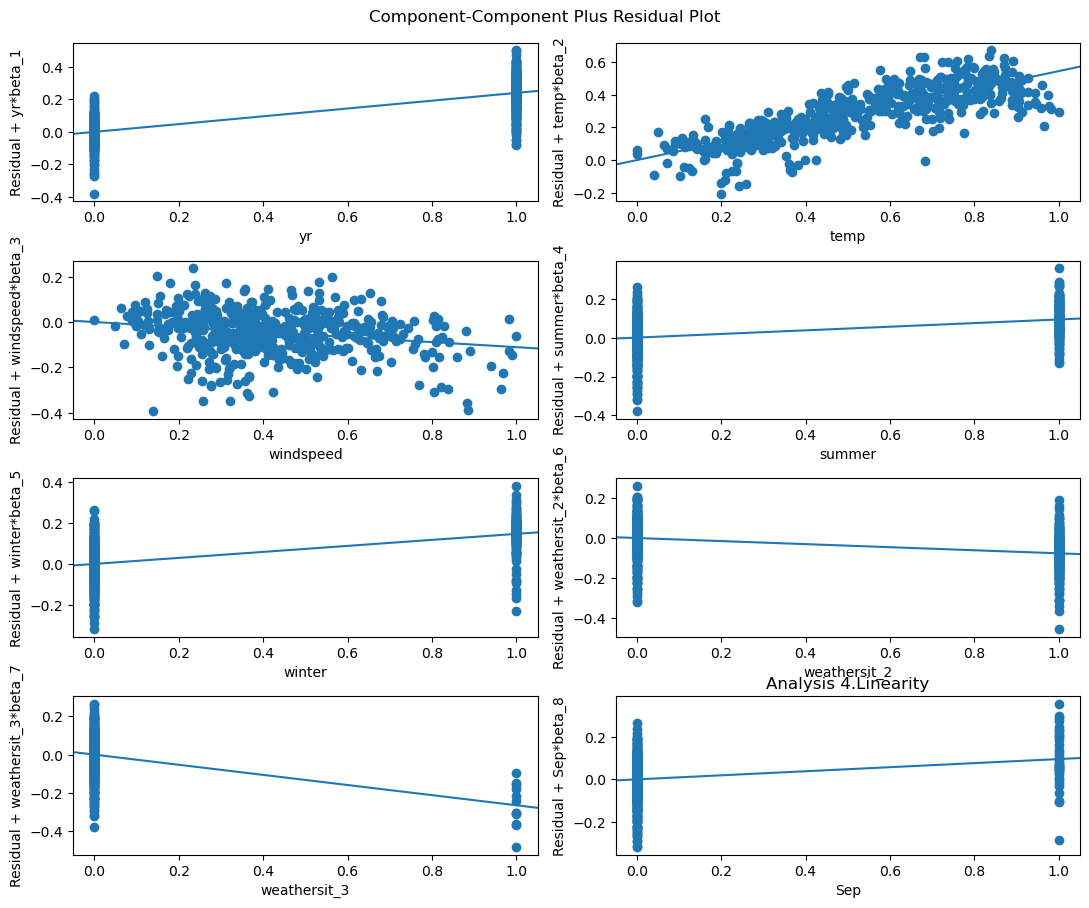

In [73]:
# residual analysis for model 1
residualAnalysis(lr_model1, X_train1, y_train1)

Analysis 1: Residual Plot : 
 Values Should be normally distributed


<Figure size 400x200 with 0 Axes>

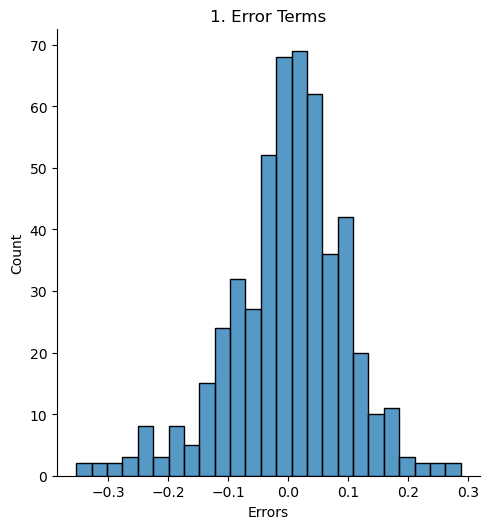

Analysis 2. Independence of residuals 
 durbin_watson :  2.128320011317093
Analysis 3 : Homoscedasticity : 
 Should not see any patterns in below scatterplot..


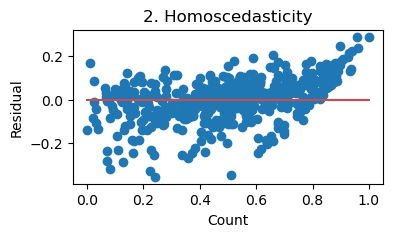

       Features   VIF
2     windspeed  4.80
1          temp  4.52
5  weathersit_1  2.81
0            yr  2.07
3        spring  1.83
4        winter  1.40
6  weathersit_3  1.09


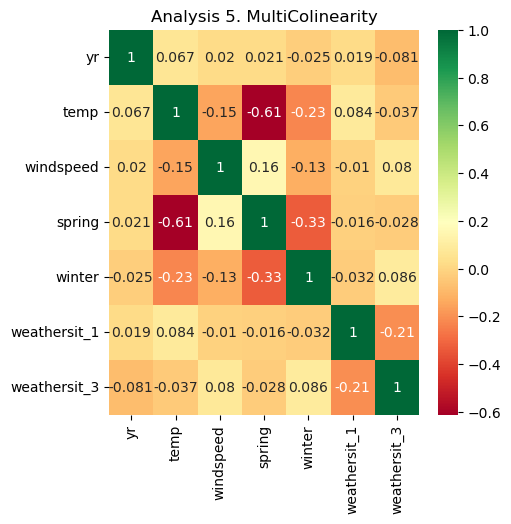

<Figure size 500x500 with 0 Axes>

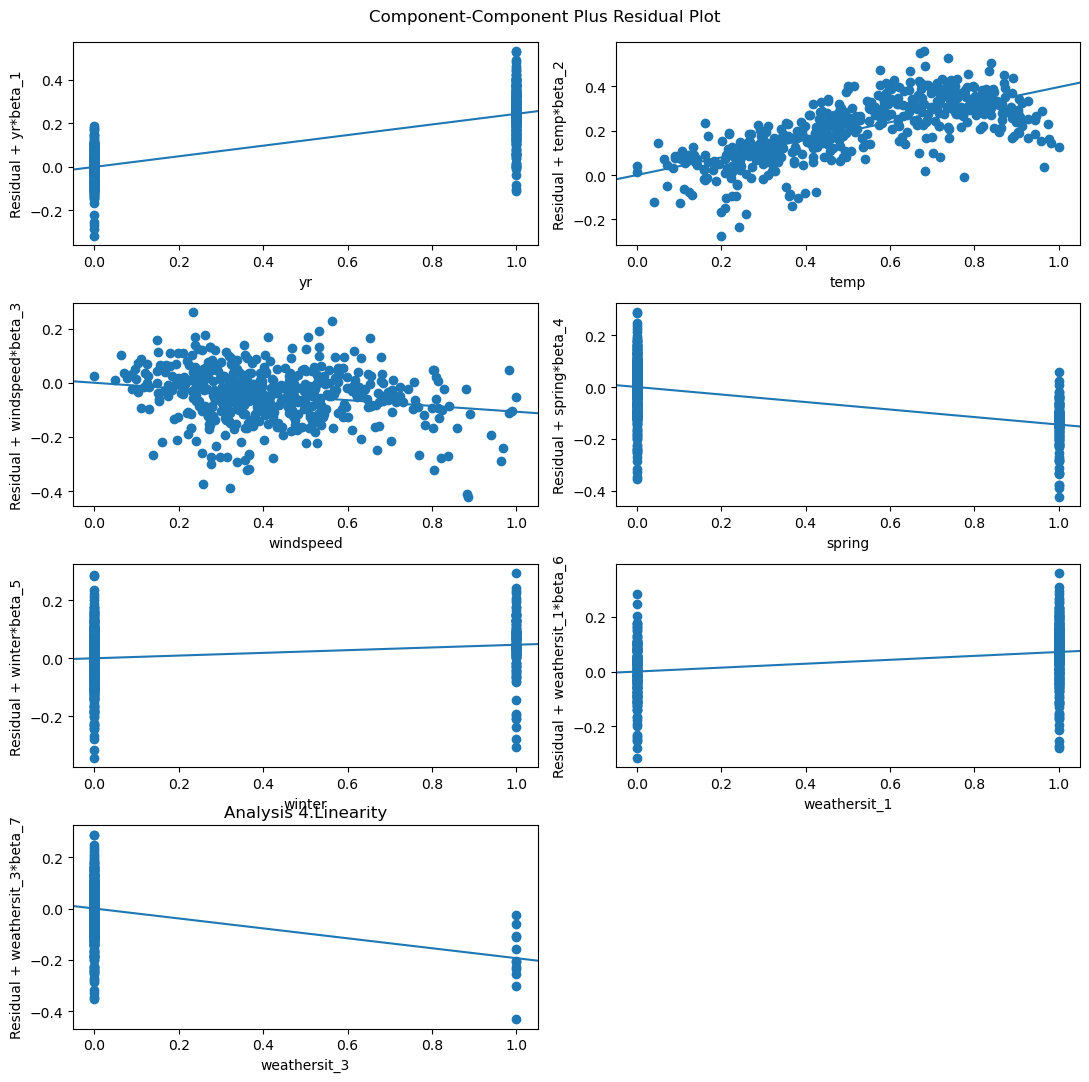

In [74]:
# residual analysis for model 2
residualAnalysis(lr_model2, X_train2, y_train2)

Analysis 1: Residual Plot : 
 Values Should be normally distributed


<Figure size 400x200 with 0 Axes>

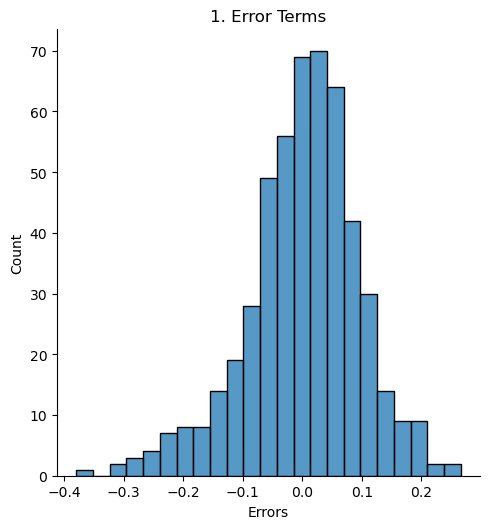

Analysis 2. Independence of residuals 
 durbin_watson :  2.1349355477087633
Analysis 3 : Homoscedasticity : 
 Should not see any patterns in below scatterplot..


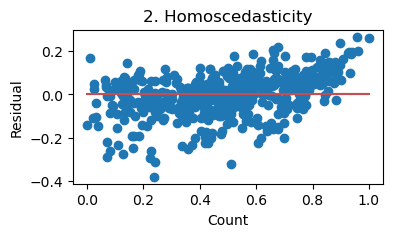

       Features   VIF
1          temp  4.29
2     windspeed  3.67
5  weathersit_1  2.69
0            yr  1.99
3        summer  1.61
4        winter  1.37
7           Sep  1.19
6  weathersit_3  1.09


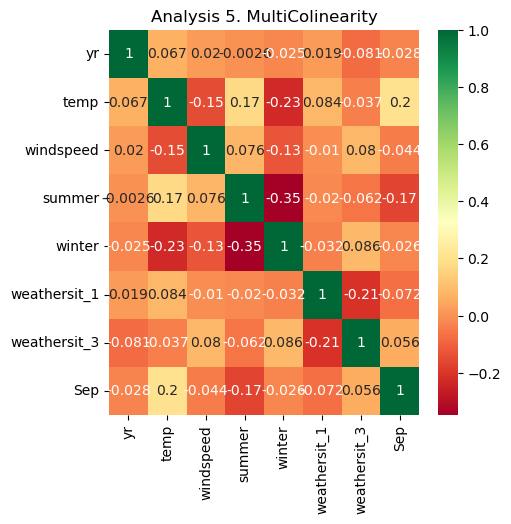

<Figure size 500x500 with 0 Axes>

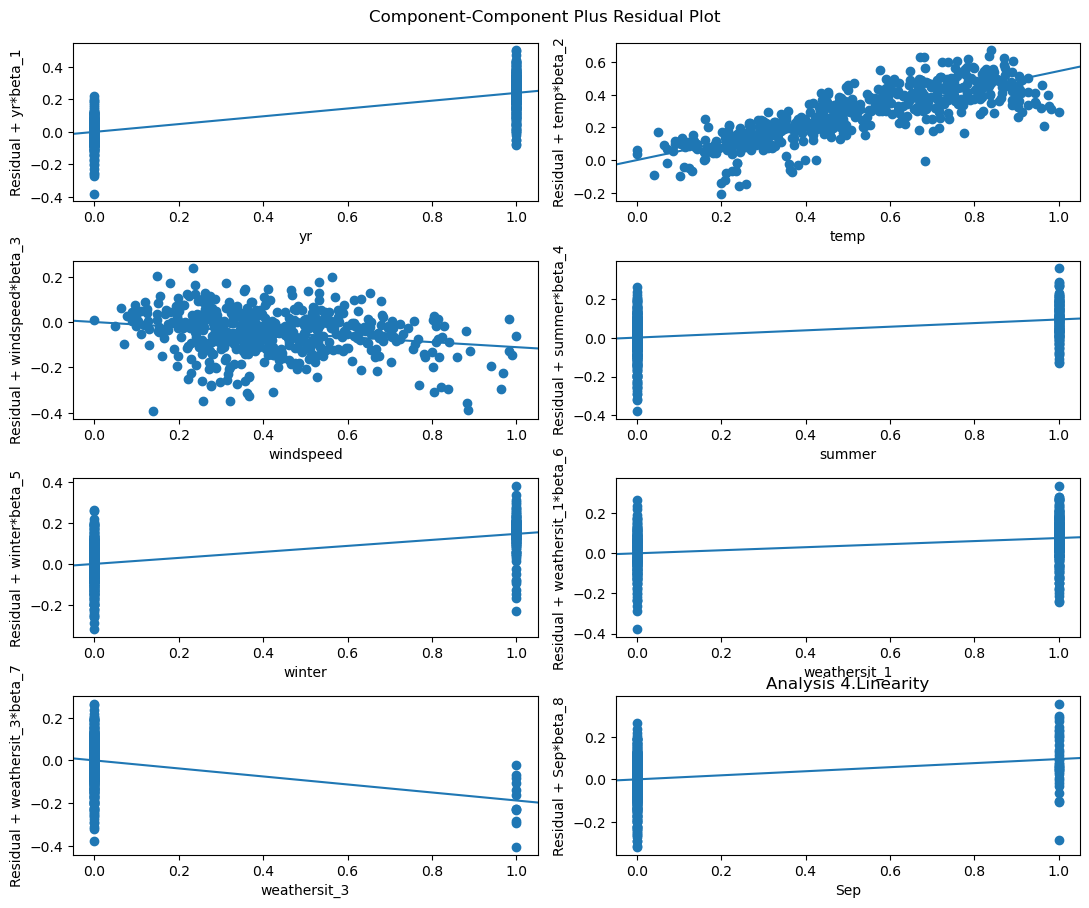

In [75]:
# residual analysis for model 3
residualAnalysis(lr_model3, X_train3, y_train3)

## Step 5 : Prediction and evaluation on the test set

In [76]:
y_test, X_test = df_test.pop('cnt'), df_test

In [77]:
def predict(model, train_data, test_data):
    # add constant
    X_test_sm = test_data[train_data.columns]
    X_test_sm = sm.add_constant(X_test_sm)
    X_test_sm
    # do predictions
    y_test_pred = model.predict(X_test_sm)
    return y_test_pred
def evaluater2score(y_test_pred, y_true):
    #calculate r2_score
    return round(r2_score(y_true=y_true, y_pred=y_test_pred), 4)

# Calculating Adjusted-R^2 value for the test dataset
def evaluate_adjustedr2(r2, test_data):
    adjusted_r2 = round(1-(1-r2)*(test_data.shape[0]-1)/(test_data.shape[0]-test_data.shape[1]-1),4)
    return round(adjusted_r2, 4)

def plotActual2Prediction(y_test_pred, y_true):
    # Visualizing the fit on the test data
    # plotting a Regression plot
    plt.figure(figsize=(5, 4))
    sns.regplot(x=y_true, y=y_test_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
    plt.title('y_true vs y_test_pred', fontsize=20)
    plt.xlabel('y_true', fontsize=18)
    plt.ylabel('y_test_pred', fontsize=16)
    plt.show()
    
def evaluateTestSet(model, train_data, test_data, y_true):
    y_test_pred = predict(model, train_data, test_data)
    r2_score = evaluater2score(y_test_pred, y_true)
    print('r2score : ',r2_score)
    print('adjusted r2 : ', evaluate_adjustedr2(r2_score, test_data))
    plotActual2Prediction(y_test_pred, y_true)                                      

r2score :  0.8092
adjusted r2 :  0.7824


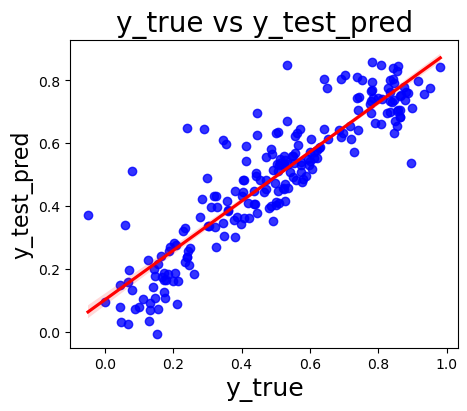

In [78]:
evaluateTestSet(lr_model1, X_train1, X_test, y_test)

r2score :  0.8011
adjusted r2 :  0.7731


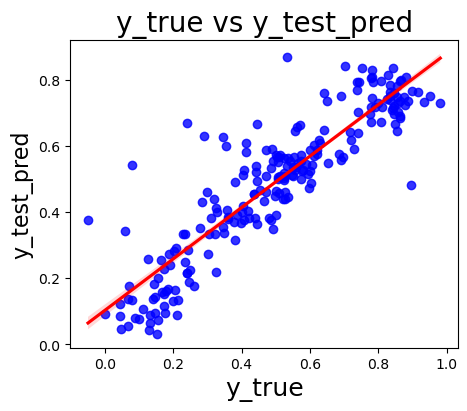

In [79]:
evaluateTestSet(lr_model2, X_train2, X_test, y_test)

r2score :  0.8092
adjusted r2 :  0.7824


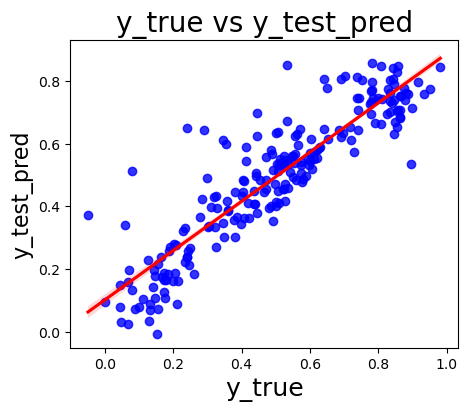

In [80]:
evaluateTestSet(lr_model3, X_train3, X_test, y_test)

## Step 6 : Summary 

## Appendix A : RFE : Gradual feature removal steps [ for Approach 2 in Step 3]

In [81]:
X_train2 = X_train

In [82]:
lr_model2 = buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.133830
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
fall            0.019641
spring         -0.061627
summer          0.068949
winter          0.106866
weathersit_1    0.139346
weathersit_2    0.085616
weathersit_3   -0.091132
Apr             0.000825
Aug             0.027930
Dec            -0.031396
Feb            -0.012932
Jan            -0.035582
Jul             0.006352
Jun             0.015357
Mar             0.001779
May             0.019865
Nov            -0.017383
Oct             0.059491
Sep             0.099524
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.84

In [83]:
#X_try= X_train2.drop(['holiday', 'winter','Sep'], axis=1)
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.133830
yr              0.241311
holiday        -0.046638
weekday         0.008054
workingday      0.019260
temp            0.400694
hum            -0.159151
windspeed      -0.136333
day_of_month   -0.000635
fall            0.019641
spring         -0.061627
summer          0.068949
winter          0.106866
weathersit_1    0.139346
weathersit_2    0.085616
weathersit_3   -0.091132
Apr             0.000825
Aug             0.027930
Dec            -0.031396
Feb            -0.012932
Jan            -0.035582
Jul             0.006352
Jun             0.015357
Mar             0.001779
May             0.019865
Nov            -0.017383
Oct             0.059491
Sep             0.099524
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.84

In [84]:
rfe = runRFE(22, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 27 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: weekday, Selected False, Rank: 2.000
Column: workingday, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: day_of_month, Selected False, Rank: 2.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Apr, Selected True, Rank: 1.000
Column: Aug, Selected True, Rank: 1.000
Column: Dec, Selected True, Rank: 1.000
Column: Feb, Selected True, Rank: 1.000
Column: Jan, Selected True, Rank: 1.000
Column: Jul, Selected False, Rank: 2.000
Column: Jun, Selected False, Rank: 2.000
Column: Mar, 

In [85]:
#X_train1 = X_train1
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.160596
yr              0.241663
holiday        -0.054633
workingday      0.022418
temp            0.392236
hum            -0.175579
windspeed      -0.136579
fall            0.023097
spring         -0.052158
summer          0.078150
winter          0.111507
weathersit_1    0.145565
weathersit_2    0.095598
weathersit_3   -0.080568
Apr            -0.018805
Aug             0.019296
Dec            -0.049624
Feb            -0.032228
Jan            -0.056410
Mar            -0.018592
Nov            -0.029308
Oct             0.047809
Sep             0.092690
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     135.0
Date:                Wed, 08 Feb 2023   Prob

In [86]:
rfe = runRFE(20, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 22 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: workingday, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Apr, Selected False, Rank: 2.000
Column: Aug, Selected False, Rank: 2.000
Column: Dec, Selected True, Rank: 1.000
Column: Feb, Selected True, Rank: 1.000
Column: Jan, Selected True, Rank: 1.000
Column: Mar, Selected True, Rank: 1.000
Column: Nov, Selected True, Rank: 1.000
Column: Oct, Selected True, Rank: 1.000
Column: Sep, Selected True, Rank: 1.000


In [87]:
#X_train1 = X_train
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.153010
yr              0.241007
holiday        -0.056011
workingday      0.022233
temp            0.405668
hum            -0.171539
windspeed      -0.137558
fall            0.027704
spring         -0.055587
summer          0.070296
winter          0.110598
weathersit_1    0.143785
weathersit_2    0.094167
weathersit_3   -0.084942
Dec            -0.044529
Feb            -0.024542
Jan            -0.047745
Mar            -0.010461
Nov            -0.025565
Oct             0.049098
Sep             0.087209
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     149.9
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.28e-186
Time:          

In [88]:
rfe = runRFE(17, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 20 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: workingday, Selected False, Rank: 2.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Dec, Selected True, Rank: 1.000
Column: Feb, Selected False, Rank: 2.000
Column: Jan, Selected True, Rank: 1.000
Column: Mar, Selected False, Rank: 2.000
Column: Nov, Selected True, Rank: 1.000
Column: Oct, Selected True, Rank: 1.000
Column: Sep, Selected True, Rank: 1.000


In [89]:
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.157647
yr              0.239871
holiday        -0.072312
temp            0.426852
hum            -0.182671
windspeed      -0.142330
fall            0.030402
spring         -0.059293
summer          0.077732
winter          0.108806
weathersit_1    0.142520
weathersit_2    0.095755
weathersit_3   -0.080628
Dec            -0.028762
Jan            -0.026813
Nov            -0.010715
Oct             0.059409
Sep             0.093024
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.3
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.14e-188
Time:                        15:37:43   Log-Likelihood:                 508.17
No. Observa

In [90]:
#X_train1.drop(['hum'], axis=1, inplace=True)
rfe = runRFE(15, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 17 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Dec, Selected False, Rank: 2.000
Column: Jan, Selected True, Rank: 1.000
Column: Nov, Selected False, Rank: 2.000
Column: Oct, Selected True, Rank: 1.000
Column: Sep, Selected True, Rank: 1.000


In [91]:
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.153846
yr              0.239569
holiday        -0.073762
temp            0.437246
hum            -0.190305
windspeed      -0.141085
fall            0.031286
spring         -0.058316
summer          0.081782
winter          0.099095
weathersit_1    0.140361
weathersit_2    0.094119
weathersit_3   -0.080634
Jan            -0.019842
Oct             0.074452
Sep             0.098214
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          4.26e-190
Time:                        15:37:43   Log-Likelihood:                 507.11
No. Observations:                 510   AIC:                 

In [92]:
rfe = runRFE(12, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 15 features.
Column: yr, Selected True, Rank: 1.000
Column: holiday, Selected False, Rank: 2.000
Column: temp, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Jan, Selected False, Rank: 2.000
Column: Oct, Selected False, Rank: 2.000
Column: Sep, Selected True, Rank: 1.000


In [93]:
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.145290
yr              0.238379
temp            0.476743
hum            -0.194115
windspeed      -0.140748
fall            0.015740
spring         -0.064116
summer          0.072171
winter          0.121494
weathersit_1    0.134761
weathersit_2    0.091039
weathersit_3   -0.080510
Sep             0.090147
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     250.0
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.85e-187
Time:                        15:37:43   Log-Likelihood:                 491.60
No. Observations:                 510   AIC:                            -961.2
Df Residuals:                     499   BIC:             

In [94]:
X_train2 = X_train2.drop(['hum'], axis=1)
rfe = runRFE(10, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 11 features.
Column: yr, Selected True, Rank: 1.000
Column: temp, Selected True, Rank: 1.000
Column: windspeed, Selected True, Rank: 1.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000
Column: Sep, Selected False, Rank: 2.000


In [95]:
buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.067076
yr              0.242902
temp            0.431835
windspeed      -0.109788
fall            0.018974
spring         -0.093837
summer          0.050459
winter          0.091480
weathersit_1    0.133546
weathersit_2    0.061178
weathersit_3   -0.127649
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     282.4
Date:                Wed, 08 Feb 2023   Prob (F-statistic):          3.43e-180
Time:                        15:37:43   Log-Likelihood:                 469.40
No. Observations:                 510   AIC:                            -920.8
Df Residuals:                     501   BIC:                            -882.7
Df Model:                   

In [96]:
rfe = runRFE(8, X_train2, y_train2)
X_train2 = removeUnsupportedColumns(rfe, X_train2)

Fitting estimator with 10 features.
Column: yr, Selected False, Rank: 2.000
Column: temp, Selected True, Rank: 1.000
Column: windspeed, Selected False, Rank: 2.000
Column: fall, Selected True, Rank: 1.000
Column: spring, Selected True, Rank: 1.000
Column: summer, Selected True, Rank: 1.000
Column: winter, Selected True, Rank: 1.000
Column: weathersit_1, Selected True, Rank: 1.000
Column: weathersit_2, Selected True, Rank: 1.000
Column: weathersit_3, Selected True, Rank: 1.000


In [97]:
#X_train1 = X_train
lr_model2 = buildAndTrainModel(list(X_train2.columns), X_train2, y_train2)
calculateVIF(X_train2)

(const           0.061063
temp            0.556270
fall           -0.012555
spring         -0.064845
summer          0.035889
winter          0.102575
weathersit_1    0.154148
weathersit_2    0.084044
weathersit_3   -0.177128
dtype: float64, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     95.37
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           9.58e-80
Time:                        15:37:43   Log-Likelihood:                 228.01
No. Observations:                 510   AIC:                            -442.0
Df Residuals:                     503   BIC:                            -412.4
Df Model:                           6                                         

In [98]:
## Probable Model 2
lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     95.37
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           9.58e-80
Time:                        15:37:43   Log-Likelihood:                 228.01
No. Observations:                 510   AIC:                            -442.0
Df Residuals:                     503   BIC:                            -412.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0611      0.019      3.154      0.002       0.023       0.099
temp             0.5563      0.052     10.752      0.000       0.455       0.658
fall            -0.0126      0.023     -0.555      0.579      -0.057       0.032
spring          -0.0648      0.015     -4.189      0.000      -0.095      -0.034
summer           0.0359      0.014      2.485      0.013       0.008       0.064
winter           0.1026      0.012      8.576      0.000       0.079       0.126
weathersit_1     0.1541      0.015     10.016      0.000       0.124       0.184
weathersit_2     0.0840      0.016      5.234      0.000       0.052       0.116
weathersit_3    -0.1771      0.034     -5.247      0.000      -0.243      -0.111
==============================================================================
Omnibus:                       14.991   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.193
Skew:                           0.104   Prob(JB):                       0.0166
Kurtosis:                       2.415   Cond. No.                     1.09e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.89e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [99]:
lr_model1.params

const           0.093700
yr              0.240337
temp            0.545839
windspeed      -0.111067
summer          0.093180
winter          0.146942
weathersit_2   -0.076342
weathersit_3   -0.264067
Sep             0.095763
dtype: float64